In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import efficientnet.keras as efn

In [3]:
model = efn.EfficientNetB0(weights='imagenet')

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [4]:
model.input_shape

(None, 224, 224, 3)

In [5]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

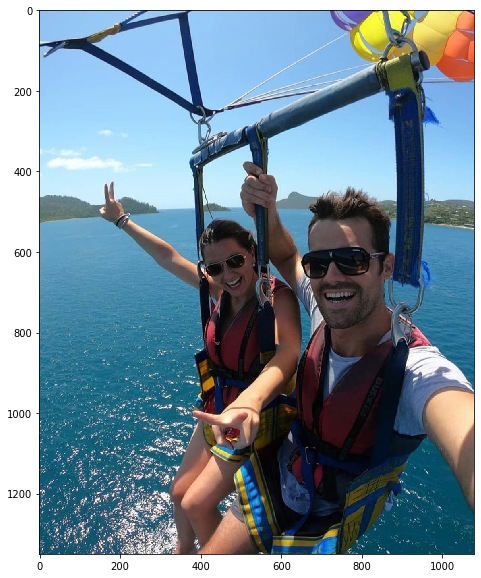

In [6]:
image = imread('test.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [7]:
from keras.applications.imagenet_utils import decode_predictions
from efficientnet.keras import center_crop_and_resize, preprocess_input


In [8]:
image_size = model.input_shape[1]
x = center_crop_and_resize(image, image_size=image_size)
x = preprocess_input(x)
x = np.expand_dims(x, 0)

# make prediction and decode
y = model.predict(x)
decode_predictions(y)

[[('n04251144', 'snorkel', 0.82332194),
  ('n02641379', 'gar', 0.025561633),
  ('n03873416', 'paddle', 0.014393715),
  ('n04371774', 'swing', 0.008793258),
  ('n02951358', 'canoe', 0.006751093)]]

In [9]:
if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
  !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
  !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
else:
  print("dataset already exist.")

!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

dataset already exist.
Cat  Dog
total 408428
-rw-rw-r-- 1 ec2-user ec2-user   34297 Feb 10  2017 9955.jpg
-rw-rw-r-- 1 ec2-user ec2-user   26013 Feb 10  2017 9956.jpg
-rw-rw-r-- 1 ec2-user ec2-user   26293 Feb 10  2017 9957.jpg
-rw-rw-r-- 1 ec2-user ec2-user   36293 Feb 10  2017 9958.jpg
-rw-rw-r-- 1 ec2-user ec2-user   36690 Feb 10  2017 9959.jpg
-rw-rw-r-- 1 ec2-user ec2-user   15262 Feb 10  2017 9960.jpg
-rw-rw-r-- 1 ec2-user ec2-user   49493 Feb 10  2017 9961.jpg
-rw-rw-r-- 1 ec2-user ec2-user   14785 Feb 10  2017 9962.jpg
-rw-rw-r-- 1 ec2-user ec2-user   39717 Feb 10  2017 9963.jpg
ls: write error: Broken pipe


In [10]:
from keras import models
from keras import layers
from keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline


In [11]:
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12500


In [12]:
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

In [13]:
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [14]:

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
input_shape

(150, 150, 3)

In [17]:
conv_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [19]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [20]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [21]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20


/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


41/41 [==============================] - 16s 389ms/step - loss: 2.0720 - acc: 0.4944 - val_loss: 1.7273 - val_acc: 0.5042
Epoch 2/20
41/41 [==============================] - 8s 202ms/step - loss: 1.7650 - acc: 0.5473 - val_loss: 1.7487 - val_acc: 0.5208
Epoch 3/20
41/41 [==============================] - 9s 212ms/step - loss: 1.8624 - acc: 0.5274 - val_loss: 1.8066 - val_acc: 0.5000
Epoch 4/20
41/41 [==============================] - 9s 213ms/step - loss: 1.7744 - acc: 0.5590 - val_loss: 1.2517 - val_acc: 0.6000
Epoch 5/20
41/41 [==============================] - 9s 211ms/step - loss: 1.6321 - acc: 0.5841 - val_loss: 1.3845 - val_acc: 0.5991
Epoch 6/20
41/41 [==============================] - 8s 203ms/step - loss: 1.4934 - acc: 0.5930 - val_loss: 1.1444 - val_acc: 0.6146
Epoch 7/20
41/41 [==============================] - 9s 216ms/step - loss: 1.4240 - acc: 0.5986 - val_loss: 1.2209 - val_acc: 0.6062
Epoch 8/20
41/41 [==============================] - 8s 206ms/step - loss: 1.4164 - acc

In [23]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

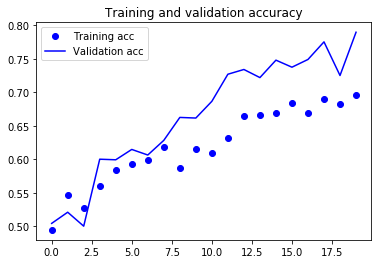

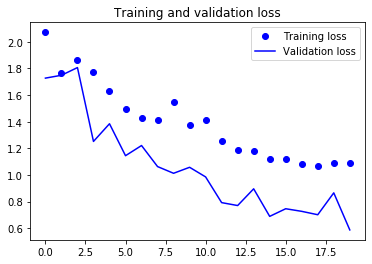

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

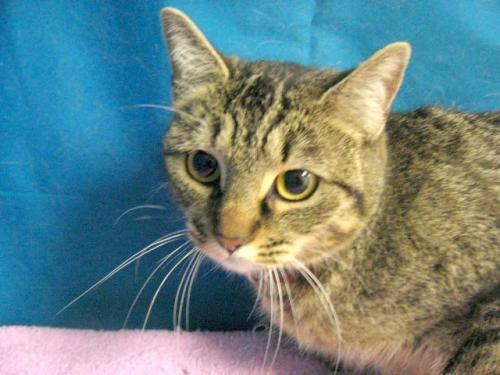

In [26]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]
Image(filename=cat_img)

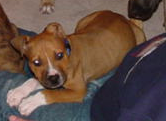

In [27]:
Image(filename=dog_img)

In [28]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.99433655)
('dog', 0.9912706352770329)
